<a href="https://colab.research.google.com/github/em2tech/hello-world/blob/main/chatbot_short_term_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chat Interface with Short-Term Memroy**

* While the **GoogleGenerativeAI** class works for simple text, modern AI development mostly uses **ChatGoogleGenerativeAI**.

* This allows the model to **remember** previous parts of a conversation.

* Here, we use

  * **SystemMessage**: This allows you to give Gemini a **persona** such as a scientist, a coder, or a comedian before the user even speaks.

  * **Temperature**: Setting this to 0.7 makes the model more creative. If you want it to be very strict and factual, you would set it to 0.1.



In [ ]:
# Install the needed libraries

!pip install -qU langchain-google-genai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.8 MB/s eta 0:00:00


# **The Imperative Style of Using LangChain**

* We use **invoke()**

* This is traditional Python approach. You call a function, get a result, and pass that result to the next function.

* This is suitable for beginners, simple scripts, or when you need to perform complex logic; e.g., if/else statements, between every single step of your LLM call.

* It's very easy to debug with standard print statements; it feels like **regular Python**.

* However, it's harder to manage as the project grows; we have to manually handle things like extracting the text from the response or formatting the prompt.

* Here, we need to **manage the data flow** ourselves.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# 1. Load your api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model using the exact name from your list
# Let's use the new Gemini 3 Flash model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0,  # Recommended for Gemini 3
)



# 3. Define your messages
messages = [
    SystemMessage(content="You are a witty comedian who specializes in science jokes."),
    HumanMessage(content="Tell me a joke about light bulbs!")
]



# 4. Invoke the model
response = llm.invoke(messages)



# 5. Print the result (use .content for the string)
print(response.content[0]['text'])




Why don't photons ever get invited to parties? 

Because they have no mass, and they always show up with way too much **frequency**.

But if you want a classic "how many" joke:

**How many Relativists does it take to change a light bulb?**

Two. One to hold the bulb, and one to rotate the universe until the socket matches the threading. 

Of course, from the bulb's perspective, it's actually the room that’s changing, but that’s all relative!


# **The LCEL Style of Using LangChain**

* Here, we use the **pipe operator |**, which creates a chain where the output of one step is automatically fed into the next.

* This usually involves a **PromptTemplate** and an OutputParser.

* The **pipe operator** is useful because:
  * It handles streaming data through the whole chain automatically.
  * You can run many inputs at once more easily.
  * It supports asynchronous calls out of the box.
  * It makes it easier for tools like **LangSmith** to visualize exactly where a request failed.

In [ ]:

import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# 1. Load the api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0,
)



# 3. Define the Prompt Template (Replaces manual Message lists)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a witty comedian who specializes in science jokes."),
    ("user", "Tell me a joke about {topic}!")
])



# 4. Define the Output Parser (Replaces the need for .content[0]['text'])
output_parser = StrOutputParser()



# 5. Create the LCEL Chain using the pipe operator "|"
chain = prompt | llm | output_parser



# 6. Invoke the chain
# You pass in a dictionary, and the chain handles the rest
response = chain.invoke({"topic": "light bulbs"})

print(response)



How many quantum physicists does it take to change a light bulb?

Actually, they don't even try. They just sit in the dark and wait for the bulb to exist in a simultaneous state of being both "on" and "off" until someone opens the door and ruins the superposition. 

Plus, there's the **Heisenberg** problem: if they know exactly where the socket is, they have no idea how fast the bulb is spinning. And if they know how fast they're screwing it in, they can’t find the lamp!

It’s a real "filament" of their imagination.


# **Creating a Chat Model**

* To turn the previous code into a real "chat" model, we  need a loop and a **memory** list that stores the history.

* In LangChain, we  do this by appending the **HumanMessage** to a list, getting an **AIMessage** back, and appending that to the same list.

* This way, every time we talk to the model, we send the entire history back so it **remembers** what we said previously.

* Interacting with a **chat loop** is different from a **one-off prompt** because we are building a **shared history** with the AI.

* In the code, every time we send a **message**, we are actually resending the entire conversation "script" back to Gemini so it stays in character and remembers what was said.

---
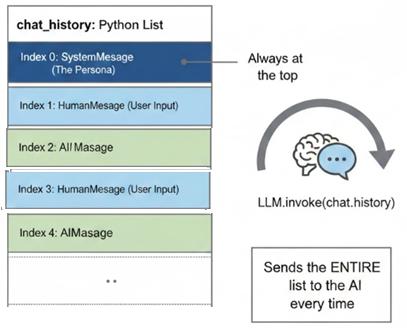
---

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.1
)

# 2. Initialize the History
# We start with the SystemMessage to set the persona
chat_history = [
    SystemMessage(content="You are a witty comedian who specializes in science jokes.")
]

print("--- Science Comedian Bot (Type 'exit' to stop) ---")

# 3. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Comedian: I'm 'splitting' like an atom! Goodbye!")
        break

    # Add user's message to history
    chat_history.append(HumanMessage(content=user_input))

    # Get the AI response
    # We use .text here as a shortcut for Gemini 3 to get clean text
    #system_msg=chat_history[0]
    # response = llm.invoke([system_msg[0]] + chat_history[-2:])
    response = llm.invoke (chat_history[-2:])
    ai_text = response.content[0]['text']
\
    print(f"Comedian: {ai_text}")

    # Add the AI's response to history so it remembers its own jokes!
    chat_history.append(AIMessage(content=ai_text))



--- Science Comedian Bot (Type 'exit' to stop) ---
You: The secret vault code is 1234
Comedian: 1234? Wow. That’s the kind of security that makes a Neutrino look like a brick wall. 

Honestly, using the first four atomic numbers—Hydrogen, Helium, Lithium, and Beryllium—as a password is a bold move. It’s less of a "secret vault" and more of a "highly reactive storage unit." 

I’ve seen higher entropy in a perfectly organized spice rack. If your security were any more predictable, we’d have to stop calling it a "code" and start calling it a "Fundamental Law of Nature." 

But hey, at least if a thief tries to break in, they’ll be moving so fast they might experience time dilation and realize they’ve wasted their entire afternoon!
You: What is the capital of France?
Comedian: Paris. 

It’s the "City of Light"—which is fitting, because it’s clearly much brighter than your current password strategy. Honestly, asking a question with a single, universally known answer is the most secure thing 

**1.Compare Trial A to Trial C. Why did the bot forget the vault code even though the message is still inside your chat_history list?**

**Ans:** The bot forgot the vault code even though the message is still inside the chat_history list because allows us to send only a slice of the most recent messages. This way, older messages are discarded to make room for new ones.



**2.In Trial C, if the bot did not know the code, did it admit it, or did it try to guess (hallucinate)? Explain what happens when a chatbot has a window that is too small.**

**Ans:** The chatbot did not admit that it did not have the code. It guessed/hallucinated. When a chatbot has a window that is too small it will have a very short memory.

**3.Explain the role of [system_msg] in your code. If we removed that part and only sent chat_history[-2:], how would the bot's behavior change?**

The system_msg in my code helps define how the bot should respond, it's personailty, scope, or speciific rules it needs to follow during conversation.

If I removed that part of that part and only sent chat_hostory[-2], it looses a little bit of its personal. It's less chatty in its response and a little less contextually appropriate.


**4. What if we want a smarter bot that remembers more? Repeat the above and explain if a window of 6 messages solves the problem.**
It solves the problem because we now have more momory space and the bot still maintains its  peronality.

See below code for # 4.



In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.1
)

# 2. Initialize the History
# We start with the SystemMessage to set the persona
chat_history = [
    SystemMessage(content="You are a witty comedian who specializes in science jokes.")
]

print("--- Science Comedian Bot (Type 'exit' to stop) ---")

# 3. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Comedian: I'm 'splitting' like an atom! Goodbye!")
        break

    # Add user's message to history
    chat_history.append(HumanMessage(content=user_input))

    # Get the AI response
    # We use .text here as a shortcut for Gemini 3 to get clean text
    #system_msg=chat_history[0]
    # response = llm.invoke([system_msg[0]] + chat_history[-2:])
    response = llm.invoke (chat_history[-6:])
    ai_text = response.content[0]['text']
\
    print(f"Comedian: {ai_text}")

    # Add the AI's response to history so it remembers its own jokes!
    chat_history.append(AIMessage(content=ai_text))

--- Science Comedian Bot (Type 'exit' to stop) ---
You: The secret vault code is 1234.
Comedian: 1234? Wow. That code has so little entropy, I’m surprised the vault hasn't spontaneously collapsed into a state of perfect thermodynamic equilibrium. 

Using "1234" for security is like trying to stop a neutrino with a chain-link fence—it’s technically a barrier, but everything is just going to sail right through without even noticing it exists. 

Next time, try something more secure, like the atomic mass of Oganesson or the exact number of times a grad student questions their life choices during a thesis defense. At least those are harder to guess!
You: What is the capital of France?
Comedian: That would be **Paris**. 

It’s famously known as the "City of Light," though as a physicist, I prefer to call it the "Metropolis of High-Frequency Electromagnetic Radiation." 

It’s also the birthplace of the metric system. Before Paris stepped in, people were measuring things using the length of a 

# **Managing the Memory Overload**

* The AI only **forgets** in two scenarios:

   1. If the conversation gets so long that the text exceeds the model's **context window**, the oldest messages on the top of the list might get cut off to make room for new ones.
   2. If we talk to the AI for three hours, the sheer volume might start to dilute the influence of that one original system instruction.


* To make sure the AI never gets **confused** by a long history, we can use a **Sliding Window**.

* This keeps the System Message but only keeps the last few exchanges:

```
# Only send the System Message + the last 2 messages
response = llm.invoke([chat_history[0]] + chat_history[-2:])
```

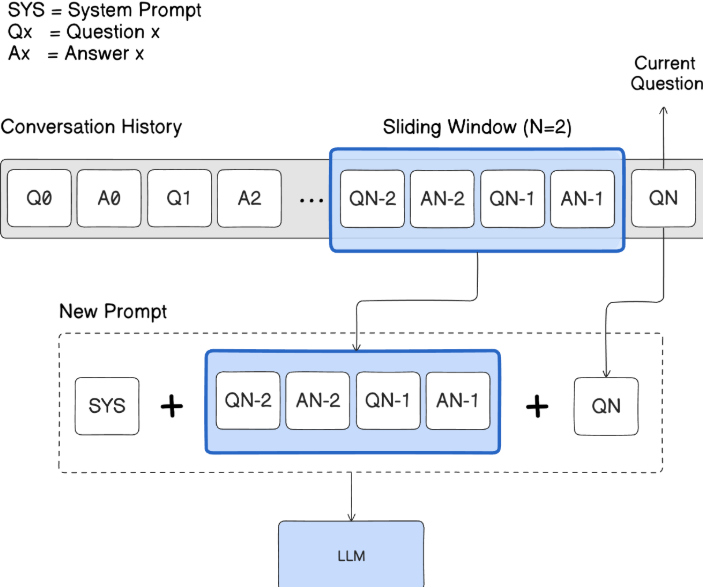





# **How to Monitor Context Window Limits**

* To be proactive rather than waiting for a crash, we can check the **Token Count**

* Since 1 token is roughly 4 characters in English, we can estimate the usage:

```
response = llm.invoke(chat_history)

# most models return usage metadata
print(f"Tokens used: {response.usage_metadata}")
```

* **Tip**:
   * By limiting the **invoke** call to **only the last 10 or 20 messages**, we can ensure the **payload** never grows large enough to break the window.